# Part 2 - Linear Regression with Statsmodels for Movie Revenue

- 06/15/22

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Last Class:
    - We started working with JUST the data data from the TMDB API for years 2000-2021. 
    - We prepared the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We fit a statsmodels linear regression.
    
    
- Today:
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.
    - We will iterate upon our model until we meet the 4 assumptions as best we can.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations (if theres time 🤞).

> **[🕹 Click here to jump to Part 2!](#🕹-Part-2:-Checking-Model-Assumptions)**

# 📺 Previously, on...

## Loading the Data

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm

In [3]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [4]:
## Checking what data we already in our Data folder using os.listdir
import os
FOLDER = 'Data/'
file_list = sorted(os.listdir(FOLDER))
# file_list

In [5]:
## Try loading in the first .csv.gz file from the list
# pd.read_csv(file_list[1])

> Why isn't it working?

In [6]:
## let's check the filepath 
# file_list[1]

In [7]:
## add the folder plus filename
# FOLDER+ file_list[1]

In [8]:
## try read csv with folder plus filename
# pd.read_csv(FOLDER+ file_list[1])

- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [9]:
import glob
## Make a filepath query
q = FOLDER+"*.csv.gz"
print(q)

Data/*.csv.gz


In [10]:
# Use glob.glob to get COMPLETE filepaths
file_list = glob.glob(q)
# file_list

In [11]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"final_*.csv.gz"
print(q)
file_list = sorted(glob.glob(q))
# file_list

Data/final_*.csv.gz


> But where are the rest of the years?

In [12]:
## in a sub-folder
# os.listdir(FOLDER+'2010-2021')

- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [13]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"/**/final_*.csv.gz"
print(q)
file_list = sorted(glob.glob(q,recursive=True))
file_list

Data//**/final_*.csv.gz


['Data/2010-2021/final_tmdb_data_2010.csv.gz',
 'Data/2010-2021/final_tmdb_data_2011.csv.gz',
 'Data/2010-2021/final_tmdb_data_2012.csv.gz',
 'Data/2010-2021/final_tmdb_data_2013.csv.gz',
 'Data/2010-2021/final_tmdb_data_2014.csv.gz',
 'Data/2010-2021/final_tmdb_data_2015.csv.gz',
 'Data/2010-2021/final_tmdb_data_2016.csv.gz',
 'Data/2010-2021/final_tmdb_data_2017.csv.gz',
 'Data/2010-2021/final_tmdb_data_2018.csv.gz',
 'Data/2010-2021/final_tmdb_data_2019.csv.gz',
 'Data/2010-2021/final_tmdb_data_2020.csv.gz',
 'Data/2010-2021/final_tmdb_data_2021.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz']

In [14]:
# ## use a list comprehension to load in all files into 1 dataframe
# df = pd.concat([pd.read_csv(f) for f in file_list])
# df

- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [15]:
## use a list comprehension to load in all files into 1 dataframe
df = pd.concat([pd.read_csv(f,lineterminator='\n') for f in file_list])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
2351,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
2352,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
2353,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [16]:
# remove ids that are 0
df = df.loc[ df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
2,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
3,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
4,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
5,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2350,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
2351,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
2352,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
2353,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [17]:
df = df.reset_index(drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
3,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
4,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60128,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


In [18]:
## saving the combined csv to disk
df.to_csv(FOLDER+'combined_tmdb_data.csv.gz',compression='gzip',index=False)

df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,NaN,0.0,[],NaN,214026.0,en,This Wretched Life,"Awakening from a near fatal overdose, Chris em...",0.600,/xMMehQD3VWgorYoqvlTeQXSbsFo.jpg,[],[],2010-01-01,0.0,0.0,[],Released,NaN,This Wretched Life,0.0,5.0,1.0,NaN
3,tt0393049,0.0,/gc9FN5zohhzCt05RkejQIIPLtBl.jpg,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,324352.0,en,Anderson's Cross,"Nick Anderson, Kevin Daniels, and Tracey Green...",2.418,/zBFUv1EjHqLaDI38sgaBoEnhepL.jpg,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-05-20,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sometimes the boy next door is more than the b...,Anderson's Cross,0.0,4.0,5.0,NaN
4,tt0398286,0.0,/cWczNud8Y8i8ab0Z4bxos4myWYO.jpg,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",http://disney.go.com/disneypictures/tangled/,38757.0,en,Tangled,When the kingdom's most wanted-and most charmi...,119.168,/ym7Kst6a4uodryxqbGOxmewF235.jpg,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-24,592461732.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're taking adventure to new lengths.,Tangled,0.0,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",NaN,595306.0,en,Cold by Nature,"Caleb Bodine and his mother Rachel, ardent ani...",0.600,NaN,"[{'id': 117146, 'logo_path': None, 'name': 'JE...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-09-01,250000.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Cold by Nature,0.0,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,NaN,0.0,[],NaN,616643.0,en,Ci qing,"""Tattoo is like a film noir situated on a diff...",0.600,/pWtd3CS2VrfGPJvuH19swbGA5Wy.jpg,[],[],2009-01-01,0.0,100.0,[],Released,NaN,Tattoo,0.0,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,NaN,0.0,[],NaN,513464.0,en,The Swell Season: One Step Away,"Recorded at the Riverside Theater, Milwaukee, ...",0.600,/zhxe5IA0LQljYQFv9RPqHpr5smH.jpg,[],[],2009-10-27,0.0,61.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Swell Season: One Step Away,0.0,0.0,0.0,NR
60128,tt9330112,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,111622.0,ta,நினைத்தாலே இனிக்கும்,Shiva gets nostalgic thinking about his colleg...,1.201,/nGOWnsmpn0LgZuCyBDXdZOIYIiA.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2009-09-04,0.0,145.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Ninaithale Inikkum,0.0,4.0,1.0,NaN


## Preprocessing

In [19]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', 'status',
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN
1,tt0326965,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13
2,tt0331312,0.0,NaN,0.0,[],0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN
3,tt0393049,0.0,NaN,300000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN
4,tt0398286,0.0,NaN,260000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13
60126,tt7786614,0.0,NaN,0.0,[],0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN
60127,tt8170758,0.0,NaN,0.0,[],0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR
60128,tt9330112,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN


### Feature Engineering


- Collection: convert to boolean
- Genres: get just name and OHE
- Cleaning Certification
- Converting release date to year, month, and day.

#### belongs to collection

In [20]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3738

In [21]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    56392
True      3738
Name: belongs_to_collection, dtype: int64

#### genre

In [22]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [23]:
## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,genres_list
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Family
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Animation
0,tt0312305,0.0,False,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,Science Fiction
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,Thriller
1,tt0326965,0.0,False,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,Mystery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Drama
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Thriller
60128,tt9330112,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,Mystery
60129,tt9556198,0.0,True,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'nam...",0.840,"[{'id': 64599, 'logo_path': None, 'name': 'SRS...",2009-08-15,0.0,80.0,Deep Sea Monster Raiga,7.7,3.0,NaN,Action


In [24]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    

## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
0,tt0312305,0.0,False,0.0,2.769,[],2012-12-02,0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0326965,0.0,False,0.0,6.120,[],2010-04-23,0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0331312,0.0,False,0.0,0.600,[],2010-01-01,0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",2010-05-20,0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",2010-11-24,592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",2009-09-01,250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt7786614,0.0,False,0.0,0.600,[],2009-01-01,0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt8170758,0.0,False,0.0,0.600,[],2009-10-27,0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9330112,0.0,False,0.0,1.201,[],2009-09-04,0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


#### certification

In [25]:
## Checking Certification values
# df['certification'].value_counts(dropna=False)

# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      45507
R         6098
NR        3270
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

#### Converting year to sep features

In [26]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)
## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,tt9330112,0.0,False,0.0,1.201,[],0.0,145.0,Ninaithale Inikkum,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   production_companies   60130 non-null  object 
 6   revenue                60130 non-null  float64
 7   runtime                59298 non-null  float64
 8   title                  60130 non-null  object 
 9   vote_average           60130 non-null  float64
 10  vote_count             60130 non-null  float64
 11  certification          14623 non-null  object 
 12  Genre_Family           60130 non-null  bool   
 13  Genre_Animation        60130 non-null  bool   
 14  Genre_Science Fiction  60130 non-null  bool   
 15  Ge

In [28]:
# df= df.drop(columns='Genre_nan')

## Train Test Split

In [29]:
drop_for_model = ['title','imdb_id','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
0,0.0,False,0.0,2.769,0.0,45.0,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
1,0.0,False,0.0,6.120,0.0,90.0,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
2,0.0,False,0.0,0.600,0.0,0.0,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
3,0.0,False,300000.0,2.418,0.0,98.0,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
4,0.0,False,260000000.0,119.168,592461732.0,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,0.0,False,0.0,0.600,250000.0,77.0,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
60126,0.0,False,0.0,0.600,0.0,100.0,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
60127,0.0,False,0.0,0.600,0.0,61.0,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0
60128,0.0,False,0.0,1.201,0.0,145.0,4.0,1.0,NaN,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,4.0


In [30]:
## Make x and y variables
y = df['revenue'].copy()
X = df.drop(columns=['revenue']).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
9538,0.0,False,0.0,1.113,80.0,5.3,5.0,NaN,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,2013.0,10.0,1.0
16553,0.0,False,0.0,1.875,92.0,6.0,2.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2015.0,4.0,15.0
34106,0.0,False,0.0,1.499,101.0,2.0,1.0,R,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2020.0,11.0,4.0
3804,0.0,False,0.0,1.506,100.0,7.7,3.0,PG,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,2011.0,9.0,24.0
37747,0.0,False,300000.0,0.600,138.0,5.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2020.0,9.0,18.0


In [31]:
X_train.isna().sum()

adult                        0
belongs_to_collection        0
budget                       0
popularity                   0
runtime                    638
vote_average                 0
vote_count                   0
certification            34082
Genre_Family                 0
Genre_Animation              0
Genre_Science Fiction        0
Genre_Thriller               0
Genre_Mystery                0
Genre_Drama                  0
Genre_Romance                0
Genre_Comedy                 0
Genre_War                    0
Genre_Crime                  0
Genre_Action                 0
Genre_Adventure              0
Genre_Horror                 0
Genre_Fantasy                0
Genre_History                0
Genre_Western                0
Genre_Music                  0
Genre_Documentary            0
Genre_TV Movie               0
year                       792
month                      792
day                        792
dtype: int64

In [32]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [33]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [34]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Family',
 'Genre_Animation',
 'Genre_Science Fiction',
 'Genre_Thriller',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Romance',
 'Genre_Comedy',
 'Genre_War',
 'Genre_Crime',
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Horror',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Western',
 'Genre_Music',
 'Genre_Documentary',
 'Genre_TV Movie']

In [35]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [36]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((num_pipe, num_cols),
                                       (cat_pipe,cat_cols),remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])])

In [37]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-2']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [38]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

36

In [39]:
preprocessor.transform(X_train).shape

(45097, 36)

In [40]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,0.0,1.499,101.0,2.0,1.0,2020.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,0.0,1.506,100.0,7.7,3.0,2011.0,9.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,300000.0,0.600,138.0,5.0,2.0,2020.0,9.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie
19252,0.0,1000.0,1.422,70.0,0.0,0.0,2015.0,12.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40663,0.0,0.0,3.180,99.0,7.0,4.0,2021.0,11.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35595,0.0,0.0,3.285,0.0,6.4,16.0,2019.0,8.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,0.0,0.0,1.052,90.0,5.0,4.0,2010.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44055,0.0,26000000.0,16.946,126.0,7.4,1011.0,2021.0,2.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Adding a Constant for Statsmodels

In [42]:
##import statsmodels correctly
import statsmodels.api as sm

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [43]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
display(X_train_df.head(2),X_test_df.head(2))

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
9538,0.0,0.0,1.113,80.0,5.3,5.0,2013.0,10.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16553,0.0,0.0,1.875,92.0,6.0,2.0,2015.0,4.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
19252,0.0,1000.0,1.422,70.0,0.0,0.0,2015.0,12.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,0.0,3.180,99.0,7.0,4.0,2021.0,11.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 🕹 Part 2: Checking Model Assumptions

## Modeling

### Statsmodels OLS

In [44]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3972.
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:08:58   Log-Likelihood:            -8.4213e+05
No. Observations:               45097   AIC:                         1.684e+06
Df Residuals:                   45061   BIC:                         1.685e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  1.371e+06   3.64e+06      0.376      0.707   -5.77e+06    8.51e+06
budget                    1.5448      0.014    110.732      0.000       1.517       1.572
popularity             1.419e+05   4441.421     31.954      0.000    1.33e+05    1.51e+05
runtime               -6249.4768   5192.945     -1.203      0.229   -1.64e+04    3928.782
vote_average          -4.954e+05   6.07e+04     -8.155      0.000   -6.14e+05   -3.76e+05
vote_count             2.895e+04    198.629    145.762      0.000    2.86e+04    2.93e+04
year                    2.57e+04   2.64e+04      0.972      0.331   -2.61e+04    7.75e+04
month                 -8.267e+04    4.2e+04     -1.968      0.049   -1.65e+05    -335.885
day                   -1.436e+04   1.62e+04     -0.886      0.376   -4.61e+04    1.74e+04
certification_G       -5.295e+06   6.82e+06     -0.776      0.438   -1.87e+07    8.08e+06
certification_MISSING -2.089e+06    6.7e+06     -0.312      0.755   -1.52e+07     1.1e+07
certification_NC-17   -6.958e+06   7.13e+06     -0.976      0.329   -2.09e+07    7.01e+06
certification_NR       -3.31e+06   6.72e+06     -0.492      0.622   -1.65e+07    9.87e+06
certification_PG      -1.681e+06    6.7e+06     -0.251      0.802   -1.48e+07    1.15e+07
certification_PG-13   -1.082e+07   6.67e+06     -1.623      0.105   -2.39e+07    2.25e+06
certification_R       -1.659e+07   6.64e+06     -2.500      0.012   -2.96e+07   -3.58e+06
belongs_to_collection  1.158e+07   6.56e+05     17.642      0.000    1.03e+07    1.29e+07
Genre_Family           -1.38e+06   7.42e+05     -1.859      0.063   -2.83e+06    7.49e+04
Genre_Animation        4.821e+05    9.2e+05      0.524      0.600   -1.32e+06    2.29e+06
Genre_Science Fiction -5.211e+06   6.74e+05     -7.730      0.000   -6.53e+06   -3.89e+06
Genre_Thriller        -1.327e+06   4.29e+05     -3.095      0.002   -2.17e+06   -4.86e+05
Genre_Mystery         -2.097e+06   6.88e+05     -3.046      0.002   -3.45e+06   -7.48e+05
Genre_Drama           -3.558e+05   3.37e+05     -1.054      0.292   -1.02e+06    3.06e+05
Genre_Romance           2.86e+04   4.59e+05      0.062      0.950   -8.72e+05    9.29e+05
Genre_Comedy          -3.946e+05   3.62e+05     -1.091      0.275    -1.1e+06    3.14e+05
Genre_War             -1.922e+06   1.23e+06     -1.559      0.119   -4.34e+06    4.95e+05
Genre_Crime           -2.812e+06   5.87e+05     -4.792      0.000   -3.96e+06   -1.66e+06
Genre_Action          -1.452e+06   5.04e+05     -2.880      0.004   -2.44e+06   -4.64e+05
Genre_Adventure        2.352e+06   7.41e+05      3.174      0.002       9e+05    3.81e+06
Genre_Horror          -5.668e+04   4.57e+05     -0.124      0.901   -9.53e+05     8.4e+05
Genre_Fantasy         -1.223e+06   7.42e+05     -1.648      0.099   -2.68e+06    2.31e+05
Genre_History         -

In [45]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)

print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)

print(f'Test R^2: {r2_score(y_test, y_hat_test):.3f}')


Training R^2: 0.755
Test R^2: 0.756


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ-Plot for Checking for Normality

<AxesSubplot:ylabel='Count'>

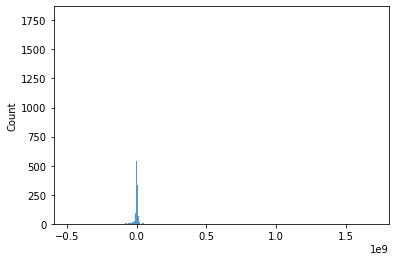

In [47]:
## Create a Q-QPlot
resids = y_train - y_hat_train
sns.histplot(resids)

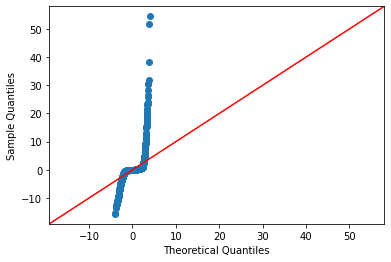

In [50]:
# first calculate residuals 
sm.graphics.qqplot(resids, fit=True, line='45');
## then use sm's qqplot with line='45' fit=True

### Residual Plot for Checking Homoscedasticity

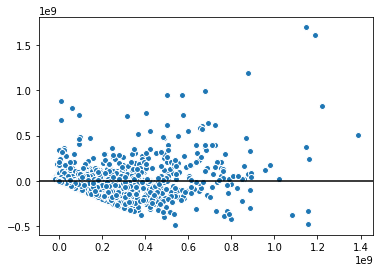

In [56]:
## Plot scatterplot with y_hat_test vs resids
plt.scatter(y_hat_train, resids, ec='white')
plt.axhline(0,color='k');

### Putting it all together into a function

In [57]:
def evaluate_ols(result,X_train_df, y_train, show_summary=True):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3972.
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:17:47   Log-Likelihood:            -8.4213e+05
No. Observations:               45097   AIC:                         1.684e+06
Df Residuals:                   45061   BIC:                         1.685e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adult                  1.371e+06   3.64e+06      0.376      0.707   -5.77e+06    8.51e+06
budget                    1.5448      0.014    110.732      0.000       1.517       1.572
popularity             1.419e+05   4441.421     31.954      0.000    1.33e+05    1.51e+05
runtime               -6249.4768   5192.945     -1.203      0.229   -1.64e+04    3928.782
vote_average          -4.954e+05   6.07e+04     -8.155      0.000   -6.14e+05   -3.76e+05
vote_count             2.895e+04    198.629    145.762      0.000    2.86e+04    2.93e+04
year                    2.57e+04   2.64e+04      0.972      0.331   -2.61e+04    7.75e+04
month                 -8.267e+04    4.2e+04     -1.968      0.049   -1.65e+05    -335.885
day                   -1.436e+04   1.62e+04     -0.886      0.376   -4.61e+04    1.74e+04
certification_G       -5.295e+06   6.82e+06     -0.776      0.438   -1.87e+07    8.08e+06
certification_MISSING -2.089e+06    6.7e+06     -0.312      0.755   -1.52e+07     1.1e+07
certification_NC-17   -6.958e+06   7.13e+06     -0.976      0.329   -2.09e+07    7.01e+06
certification_NR       -3.31e+06   6.72e+06     -0.492      0.622   -1.65e+07    9.87e+06
certification_PG      -1.681e+06    6.7e+06     -0.251      0.802   -1.48e+07    1.15e+07
certification_PG-13   -1.082e+07   6.67e+06     -1.623      0.105   -2.39e+07    2.25e+06
certification_R       -1.659e+07   6.64e+06     -2.500      0.012   -2.96e+07   -3.58e+06
belongs_to_collection  1.158e+07   6.56e+05     17.642      0.000    1.03e+07    1.29e+07
Genre_Family           -1.38e+06   7.42e+05     -1.859      0.063   -2.83e+06    7.49e+04
Genre_Animation        4.821e+05    9.2e+05      0.524      0.600   -1.32e+06    2.29e+06
Genre_Science Fiction -5.211e+06   6.74e+05     -7.730      0.000   -6.53e+06   -3.89e+06
Genre_Thriller        -1.327e+06   4.29e+05     -3.095      0.002   -2.17e+06   -4.86e+05
Genre_Mystery         -2.097e+06   6.88e+05     -3.046      0.002   -3.45e+06   -7.48e+05
Genre_Drama           -3.558e+05   3.37e+05     -1.054      0.292   -1.02e+06    3.06e+05
Genre_Romance           2.86e+04   4.59e+05      0.062      0.950   -8.72e+05    9.29e+05
Genre_Comedy          -3.946e+05   3.62e+05     -1.091      0.275    -1.1e+06    3.14e+05
Genre_War             -1.922e+06   1.23e+06     -1.559      0.119   -4.34e+06    4.95e+05
Genre_Crime           -2.812e+06   5.87e+05     -4.792      0.000   -3.96e+06   -1.66e+06
Genre_Action          -1.452e+06   5.04e+05     -2.880      0.004   -2.44e+06   -4.64e+05
Genre_Adventure        2.352e+06   7.41e+05      3.174      0.002       9e+05    3.81e+06
Genre_Horror          -5.668e+04   4.57e+05     -0.124      0.901   -9.53e+05     8.4e+05
Genre_Fantasy         -1.223e+06   7.42e+05     -1.648      0.099   -2.68e+06    2.31e+05
Genre_History         -

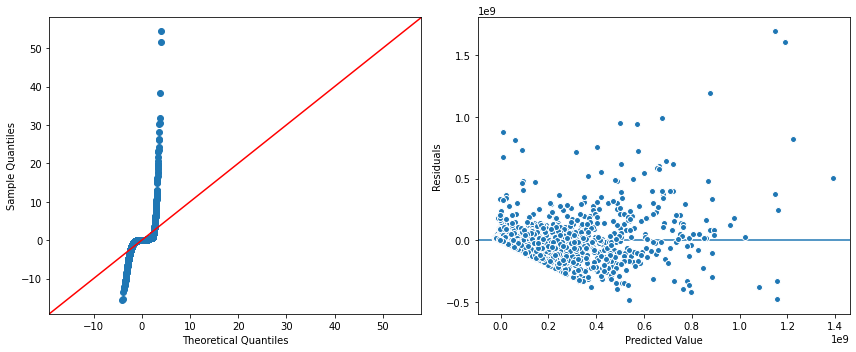

In [58]:
evaluate_ols(result,X_train_df, y_train)

# Improving Our Model:

> "Garbage In = Garbage Out"


- Before we dive into iterating on our model, I realized there were some big issues that I did not account for in the original data. 
    - some movies may not have been released. 
    - We should probably remove movies with 0 budget and revenue.
    

In [59]:
## reload the data
df = pd.read_csv(FOLDER+'combined_tmdb_data.csv.gz',lineterminator='\n')
df.head(2)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0312305,0.0,NaN,NaN,0.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",http://www.qqthemovie.com/,23738.0,en,Quantum Quest: A Cassini Space Odyssey,"Dave, a young photon, who is forced out of the...",2.769,/wflqNWF3BCwWJABjIbGWeM9hKHP.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-12-02,0.0,45.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Quantum Quest: A Cassini Space Odyssey,0.0,8.4,7.0,NaN
1,tt0326965,0.0,/xt2klJdKCVGXcoBGQrGfAS0aGDE.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",http://www.inmysleep.com,40048.0,en,In My Sleep,Marcus (Philip WInchester) wakes up in the mid...,6.120,/sv9o6VYUQM2AbfmlTwDTn9238R5.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2010-04-23,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Sleepwalking Can Be Deadly,In My Sleep,0.0,5.5,31.0,PG-13


### Repeating Feature Engineering

In [60]:
## Columns to exclude - Keeping Status and companies
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage', #'status','production_companies'
                 'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)

## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()

## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

## Use ourn function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)    


## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])


#### Fixing Certification
## Checking Certification values
df['certification'].value_counts(dropna=False)
# fix extra space certs
df['certification'] = df['certification'].str.strip()

## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)


#### Converting year to sep features
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])

## set imdb_id as index
df = df.set_index('imdb_id')
df

,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Released,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,Released,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,Released,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Released,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Released,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Released,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Released,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,Released,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0


### New Filtering

- Make sure to only keep:
    1. Status=Released.
    2. Budget >0
    3. Revenue >0

In [61]:
## Check status
df['status'].value_counts()

Released           60097
Post Production       27
In Production          6
Name: status, dtype: int64

In [62]:
## Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0312305,0.0,False,0.0,2.769,[],0.0,45.0,Quantum Quest: A Cassini Space Odyssey,8.4,7.0,NaN,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2012.0,12.0,2.0
tt0326965,0.0,False,0.0,6.120,[],0.0,90.0,In My Sleep,5.5,31.0,PG-13,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,4.0,23.0
tt0331312,0.0,False,0.0,0.600,[],0.0,0.0,This Wretched Life,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,1.0,1.0
tt0393049,0.0,False,300000.0,2.418,"[{'id': 46102, 'logo_path': None, 'name': 'Ill...",0.0,98.0,Anderson's Cross,4.0,5.0,NaN,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,5.0,20.0
tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",592461732.0,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt7661128,0.0,False,0.0,0.600,"[{'id': 117146, 'logo_path': None, 'name': 'JE...",250000.0,77.0,Cold by Nature,0.0,0.0,PG-13,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
tt7786614,0.0,False,0.0,0.600,[],0.0,100.0,Tattoo,5.0,1.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,1.0,1.0
tt8170758,0.0,False,0.0,0.600,[],0.0,61.0,The Swell Season: One Step Away,0.0,0.0,NR,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2009.0,10.0,27.0


In [63]:
## filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0398286,0.0,False,260000000.0,119.168,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",5.924617e+08,100.0,Tangled,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
tt0411951,0.0,True,30000000.0,70.694,"[{'id': 5882, 'logo_path': None, 'name': 'Namc...",9.670000e+05,92.0,Tekken,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
tt0427152,0.0,False,69000000.0,21.747,"[{'id': 2242, 'logo_path': None, 'name': 'Ever...",8.638786e+07,114.0,Dinner for Schmucks,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
tt0429493,0.0,False,110000000.0,56.494,"[{'id': 10908, 'logo_path': None, 'name': 'Pho...",1.772388e+08,117.0,The A-Team,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
tt0435761,0.0,True,200000000.0,93.983,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...",1.066970e+09,103.0,Toy Story 3,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1532382,0.0,True,3500000.0,4.838,[],3.704408e+06,97.0,Hooked on the Game,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
tt1542960,0.0,False,300000.0,1.937,"[{'id': 46722, 'logo_path': None, 'name': 'Gol...",2.000000e+05,122.0,The Figurine (Araromire),4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
tt1560950,0.0,True,600.0,1.795,[],3.000000e+00,81.0,D@bbe 2,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0


In [64]:
## Dropping columns
drop_for_model = ['title','production_companies']
df = df.drop(columns=drop_for_model)
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0398286,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
tt0411951,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
tt0427152,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
tt0429493,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
tt0435761,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1532382,0.0,True,3500000.0,4.838,3.704408e+06,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
tt1542960,0.0,False,300000.0,1.937,2.000000e+05,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
tt1560950,0.0,True,600.0,1.795,3.000000e+00,81.0,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0


# Checking for Linearity

In [72]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
## concatenating training data into plot_df
plot_df = pd.concat([X_train_df,y_train],axis=1)

genre_cols = [c for c in df.columns if c.startswith('Genre')]
plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
len(plot_cols)

18

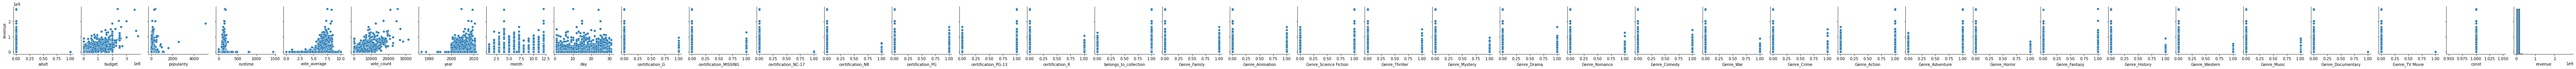

In [74]:
sns.pairplot(data=plot_df, y_vars='revenue')

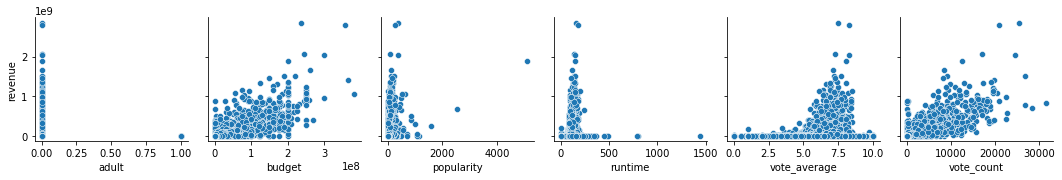

In [76]:
# ## save plot_cols list to show (dropping genre from plot_df from pair_plot)
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6])

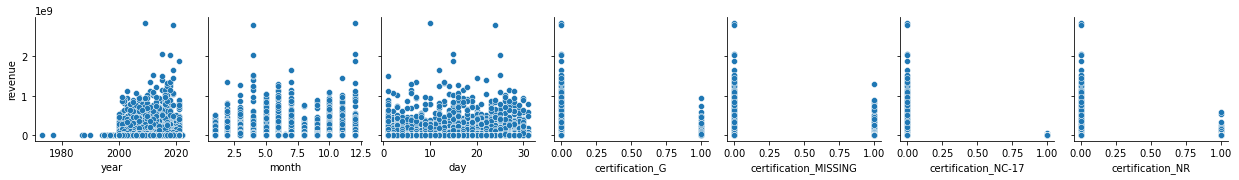

In [77]:
## Plot first 6 features
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[6:13])

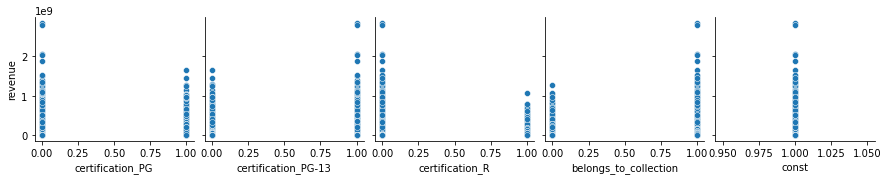

In [79]:
## Plot next 6 features
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[13:])

In [ ]:
## plot remaining features


- Shouldn't have years before 2000, so drop. 
- Check outliers in popularity, runtime


In [80]:
# remove movies prior to 2000
df = df.loc[ df['year']>=2000]
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0398286,0.0,False,260000000.0,119.168,5.924617e+08,100.0,7.6,9364.0,PG,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2010.0,11.0,24.0
tt0411951,0.0,True,30000000.0,70.694,9.670000e+05,92.0,5.4,553.0,R,False,False,True,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,2010.0,3.0,20.0
tt0427152,0.0,False,69000000.0,21.747,8.638786e+07,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
tt0429493,0.0,False,110000000.0,56.494,1.772388e+08,117.0,6.4,3877.0,PG-13,False,False,False,True,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,2010.0,6.0,9.0
tt0435761,0.0,True,200000000.0,93.983,1.066970e+09,103.0,7.8,12455.0,G,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,6.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1532382,0.0,True,3500000.0,4.838,3.704408e+06,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
tt1542960,0.0,False,300000.0,1.937,2.000000e+05,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0
tt1560950,0.0,True,600.0,1.795,3.000000e+00,81.0,1.9,10.0,NaN,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,12.0,24.0


> Now need to recreate X and y varaibles

### Functionize ALL of the preprocessing

In [82]:
def get_train_test_split(df_, y_col='revenue',drop_cols=[]):
    
    ## Make copy of input df
    df = df_.copy()
    
    ## filter columns in drop cols (if exist)
    final_drop_cols = []
    [df.drop(columns=c,inplace=True) for c in df.columns if c in drop_cols]
    
    
    ## Make x and y variables
    y = df[y_col].copy()
    X = df.drop(columns=[y_col]).copy()

    X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
    

    
    ## make cat selector and using it to save list of column names
    cat_select = make_column_selector(dtype_include='object')
    cat_cols = cat_select(X_train)


    ## make num selector and using it to save list of column names
    num_select = make_column_selector(dtype_include='number')
    num_cols = num_select(X_train)


    ## select manually OHE cols for later
    bool_select = make_column_selector(dtype_include='bool')
    already_ohe_cols = bool_select(X_train)

    ## convert manual ohe to int
    X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
    X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

    ## make pipelines
    cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                           fill_value='MISSING'),
                             OneHotEncoder(handle_unknown='ignore', sparse=False))
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                            )

    preprocessor = make_column_transformer((num_pipe, num_cols),
                                           (cat_pipe,cat_cols),remainder='passthrough')
    
    

    ## fit the col transformer
    preprocessor.fit(X_train)

    ## Finding the categorical pipeline in our col transformer.
    preprocessor.named_transformers_['pipeline-2']

    ## B) Using list-slicing to find the encoder 
    cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


    ## Create the empty list
    final_features = [*cat_features,*num_cols,*already_ohe_cols]

    ## Make df verisons of x data
    X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                              columns=final_features, index=X_train.index)


    X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                             columns=final_features, index=X_test.index)


    ### Adding a Constant for Statsmodels
    ## Make final X_train_df and X_test_df with constants added
    X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
    X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
    return X_train_df, X_test_df, y_train, y_test


In [84]:
## Use our function to make new x,y vars
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df)
X_train_df

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,const
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt3499096,0.0,5000000.0,11.465,134.0,7.3,1343.0,2016.0,2.0,19.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
tt0446013,0.0,45000000.0,17.487,99.0,5.7,518.0,2007.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tt2294629,0.0,150000000.0,136.196,102.0,7.3,14201.0,2013.0,11.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
tt0358349,0.0,26000000.0,15.666,100.0,5.5,516.0,2004.0,3.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tt0365748,0.0,6100000.0,34.034,99.0,7.5,6883.0,2004.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt6673612,0.0,175000000.0,48.140,101.0,6.7,2966.0,2020.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
tt8925540,0.0,3000000.0,5.447,90.0,5.5,22.0,2018.0,12.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tt0405676,0.0,55000000.0,9.296,125.0,5.8,231.0,2006.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     345.7
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:30:11   Log-Likelihood:                -75242.
No. Observations:                3810   AIC:                         1.506e+05
Df Residuals:                    3775   BIC:                         1.508e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G        6.942e+06   9.19e+07      0.076      0.940   -1.73e+08    1.87e+08
certification_MISSING     1.6864      0.055     30.908      0.000       1.579       1.793
certification_NC-17    1.704e+05    1.5e+04     11.391      0.000    1.41e+05       2e+05
certification_NR       2.093e+05   8.55e+04      2.448      0.014    4.17e+04    3.77e+05
certification_PG      -3.843e+06   1.49e+06     -2.584      0.010   -6.76e+06   -9.27e+05
certification_PG-13    2.944e+04    683.178     43.095      0.000    2.81e+04    3.08e+04
certification_R        1.609e+05   2.69e+05      0.597      0.550   -3.67e+05    6.89e+05
adult                 -3.034e+05   4.39e+05     -0.691      0.490   -1.16e+06    5.58e+05
budget                 1.885e+04   1.74e+05      0.108      0.914   -3.23e+05     3.6e+05
popularity            -4.812e+07   6.78e+07     -0.710      0.478   -1.81e+08    8.48e+07
runtime               -3.073e+07   6.84e+07     -0.449      0.653   -1.65e+08    1.03e+08
vote_average           -4.13e+07   7.17e+07     -0.576      0.565   -1.82e+08    9.94e+07
vote_count            -3.874e+07   6.85e+07     -0.565      0.572   -1.73e+08    9.56e+07
year                  -3.382e+07   6.78e+07     -0.499      0.618   -1.67e+08    9.91e+07
month                 -4.816e+07   6.77e+07     -0.711      0.477   -1.81e+08    8.46e+07
day                   -6.161e+07   6.78e+07     -0.909      0.363   -1.94e+08    7.13e+07
belongs_to_collection  4.701e+07   4.01e+06     11.726      0.000    3.92e+07    5.49e+07
Genre_Family           -8.67e+06   7.63e+06     -1.137      0.256   -2.36e+07    6.28e+06
Genre_Animation        2.958e+07   8.09e+06      3.656      0.000    1.37e+07    4.54e+07
Genre_Science Fiction -2.927e+07   5.56e+06     -5.268      0.000   -4.02e+07   -1.84e+07
Genre_Thriller        -5.279e+06   4.09e+06     -1.290      0.197   -1.33e+07    2.74e+06
Genre_Mystery         -1.191e+07   5.66e+06     -2.105      0.035    -2.3e+07    -8.2e+05
Genre_Drama            7.913e+05   3.88e+06      0.204      0.838   -6.81e+06     8.4e+06
Genre_Romance          4.718e+06   4.33e+06      1.090      0.276   -3.77e+06    1.32e+07
Genre_Comedy           2.352e+06   3.88e+06      0.606      0.545   -5.26e+06    9.96e+06
Genre_War              1.555e+05   8.31e+06      0.019      0.985   -1.61e+07    1.64e+07
Genre_Crime           -4.052e+06   4.68e+06     -0.866      0.387   -1.32e+07    5.12e+06
Genre_Action          -9.938e+06   4.15e+06     -2.397      0.017   -1.81e+07   -1.81e+06
Genre_Adventure        3.807e+06   4.96e+06      0.768      0.442   -5.91e+06    1.35e+07
Genre_Horror            1.48e+06   5.58e+06      0.265      0.791   -9.47e+06    1.24e+07
Genre_Fantasy         -7.814e+06    5.5e+06     -1.420      0.156   -1.86e+07    2.98e+06
Genre_History         -

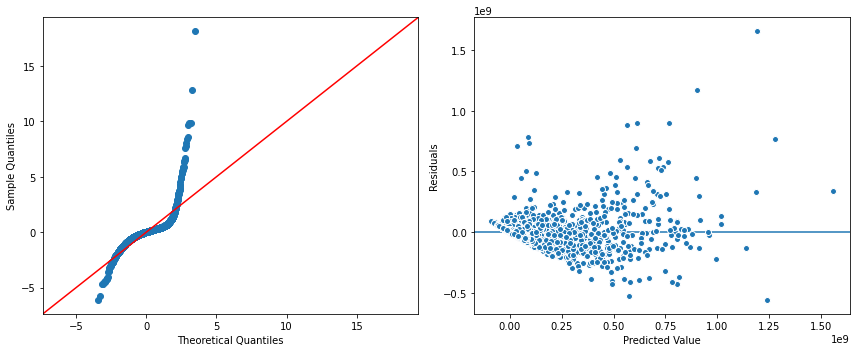

In [86]:
## instantiate an OLS model WITH the training data.
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

> How did we do? Did we meet the assumptions better?

## Removing Outliers

### Using Z-Score Rule

In [87]:
from scipy import stats
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [90]:
outlier_cols = df.select_dtypes('number').columns
outlier_cols

Index(['adult', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'year', 'month', 'day'],
      dtype='object')

In [93]:
## save a dictionary of the T/F outlier index for each feature in outleir_cols
outliers = {}

for col in outlier_cols:
    idx_outliers = find_outliers( df[col])
    outliers[col] = idx_outliers
outliers.keys()

- 1 outliers found in adult using Z-Scores.
- 141 outliers found in budget using Z-Scores.
- 34 outliers found in popularity using Z-Scores.
- 128 outliers found in revenue using Z-Scores.
- 0 outliers found in runtime using Z-Scores.
- 96 outliers found in vote_average using Z-Scores.
- 132 outliers found in vote_count using Z-Scores.
- 0 outliers found in year using Z-Scores.
- 0 outliers found in month using Z-Scores.
- 0 outliers found in day using Z-Scores.


dict_keys(['adult', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'month', 'day'])

In [94]:
outliers['revenue']

imdb_id
tt0398286    False
tt0411951    False
tt0427152    False
tt0429493    False
tt0435761     True
             ...  
tt1532382    False
tt1542960    False
tt1560950    False
tt1565058    False
tt1569364    False
Name: revenue, Length: 5081, dtype: bool

In [95]:
# Make new df_clean copy of df
df_clean = df.copy()

## loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4708 entries, tt0411951 to tt1569364
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  4708 non-null   float64
 1   belongs_to_collection  4708 non-null   bool   
 2   budget                 4708 non-null   float64
 3   popularity             4708 non-null   float64
 4   revenue                4708 non-null   float64
 5   runtime                4707 non-null   float64
 6   vote_average           4708 non-null   float64
 7   vote_count             4708 non-null   float64
 8   certification          3631 non-null   object 
 9   Genre_Family           4708 non-null   bool   
 10  Genre_Animation        4708 non-null   bool   
 11  Genre_Science Fiction  4708 non-null   bool   
 12  Genre_Thriller         4708 non-null   bool   
 13  Genre_Mystery          4708 non-null   bool   
 14  Genre_Drama            4708 non-null   bool   
 

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_71705/1104993295.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


### Model 2: Outliers Removed (Z_scores)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     268.3
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:38:34   Log-Likelihood:                -67793.
No. Observations:                3531   AIC:                         1.357e+05
Df Residuals:                    3497   BIC:                         1.359e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G          31.6723     13.893      2.280      0.023       4.434      58.911
certification_MISSING     1.2907      0.042     30.847      0.000       1.209       1.373
certification_NC-17    2.392e+05   3.99e+04      6.001      0.000    1.61e+05    3.17e+05
certification_NR       1.609e+05   5.13e+04      3.136      0.002    6.03e+04    2.61e+05
certification_PG      -9.141e+05   1.31e+06     -0.699      0.485   -3.48e+06    1.65e+06
certification_PG-13    2.345e+04    631.440     37.133      0.000    2.22e+04    2.47e+04
certification_R       -3.974e+05   1.69e+05     -2.347      0.019   -7.29e+05   -6.54e+04
adult                 -1.723e+05   2.61e+05     -0.661      0.509   -6.83e+05    3.39e+05
budget                 6.884e+04   1.05e+05      0.655      0.513   -1.37e+05    2.75e+05
popularity             1.047e+08   4.28e+07      2.446      0.014    2.08e+07    1.89e+08
runtime                1.007e+08    4.3e+07      2.341      0.019    1.64e+07    1.85e+08
vote_average           9.088e+07   4.48e+07      2.030      0.042    3.11e+06    1.79e+08
vote_count             9.695e+07    4.3e+07      2.257      0.024    1.27e+07    1.81e+08
year                   1.043e+08   4.27e+07      2.444      0.015    2.06e+07    1.88e+08
month                   9.67e+07   4.26e+07      2.271      0.023    1.32e+07     1.8e+08
day                    8.422e+07   4.26e+07      1.976      0.048    6.48e+05    1.68e+08
belongs_to_collection  3.316e+07   2.46e+06     13.457      0.000    2.83e+07     3.8e+07
Genre_Family           1.906e+06   4.67e+06      0.408      0.683   -7.24e+06    1.11e+07
Genre_Animation        9.022e+06   5.14e+06      1.755      0.079   -1.06e+06    1.91e+07
Genre_Science Fiction -2.117e+07   3.53e+06     -6.001      0.000   -2.81e+07   -1.43e+07
Genre_Thriller         1.041e+06   2.48e+06      0.420      0.675   -3.82e+06     5.9e+06
Genre_Mystery         -3.703e+06   3.35e+06     -1.104      0.270   -1.03e+07    2.87e+06
Genre_Drama           -3.102e+06   2.37e+06     -1.308      0.191   -7.75e+06    1.55e+06
Genre_Romance          5.163e+06   2.55e+06      2.026      0.043    1.66e+05    1.02e+07
Genre_Comedy           6.444e+06   2.33e+06      2.762      0.006    1.87e+06     1.1e+07
Genre_War             -8.513e+05   5.08e+06     -0.167      0.867   -1.08e+07    9.11e+06
Genre_Crime           -9.661e+06   2.81e+06     -3.437      0.001   -1.52e+07   -4.15e+06
Genre_Action          -2.735e+06    2.5e+06     -1.094      0.274   -7.64e+06    2.17e+06
Genre_Adventure       -2.361e+06   3.06e+06     -0.771      0.441   -8.36e+06    3.64e+06
Genre_Horror          -1.169e+06   3.33e+06     -0.351      0.726   -7.71e+06    5.37e+06
Genre_Fantasy         -6.238e+06    3.4e+06     -1.833      0.067   -1.29e+07    4.35e+05
Genre_History         -

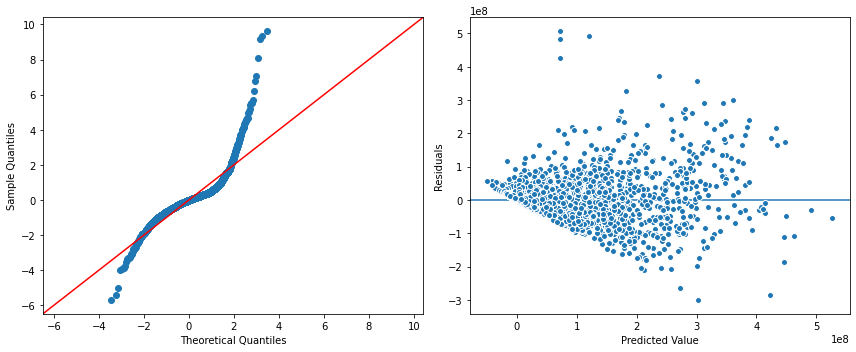

In [96]:
## instantiate an OLS model WITH the training data.
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df_clean)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

### Removing Outliers - Using IQR Rule

<AxesSubplot:xlabel='revenue'>

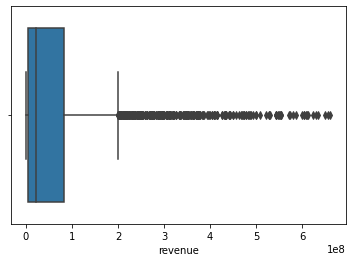

In [97]:
## visualzie outlier-removed target
sns.boxplot(x = y_train)

In [98]:
def find_outliers_IQR(data, verbose=True):
    q3 = np.quantile(data,.75)
    q1 = np.quantile(data,.25)

    IQR = q3 - q1
    upper_threshold = q3 + 1.5*IQR
    lower_threshold = q1 - 1.5*IQR
    
    outliers = (data<lower_threshold) | (data>upper_threshold)
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using IQR.")
        
    return outliers

In [ ]:
# ## use new func to find outliers in target


In [99]:
## Loop to remove outliers from same clumns using new function
outlier_cols = num_cols#['runtime','popularity','revenue']

## Empty dict for both types of outliers
outliers_z = {}
outliers_iqr = {}

## Use both functions to see the comparison for # of outliers
for col in outlier_cols:
    outliers_col_z = find_outliers(df[col])
    outliers_z[col] = outliers_col_z
    
    outliers_col_iqr = find_outliers_IQR(df[col])
    outliers_iqr[col] = outliers_col_iqr
    print()
    

- 1 outliers found in adult using Z-Scores.
- 1 outliers found in adult using IQR.

- 141 outliers found in budget using Z-Scores.
- 466 outliers found in budget using IQR.

- 34 outliers found in popularity using Z-Scores.
- 518 outliers found in popularity using IQR.

- 0 outliers found in runtime using Z-Scores.
- 0 outliers found in runtime using IQR.

- 96 outliers found in vote_average using Z-Scores.
- 148 outliers found in vote_average using IQR.

- 132 outliers found in vote_count using Z-Scores.
- 511 outliers found in vote_count using IQR.

- 0 outliers found in year using Z-Scores.
- 0 outliers found in year using IQR.

- 0 outliers found in month using Z-Scores.
- 0 outliers found in month using IQR.

- 0 outliers found in day using Z-Scores.
- 0 outliers found in day using IQR.



In [ ]:
# # remove_outliers - create df_clean_z
# df_clean_z = df.copy()

# ## loop though outliers_z


In [100]:
# remove_outliers
df_clean_iqr = df.copy()
for col, idx_outliers in outliers_iqr.items():
    df_clean_iqr = df_clean_iqr[~idx_outliers]
df_clean_iqr

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_71705/739513175.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean_iqr = df_clean_iqr[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Family,Genre_Animation,Genre_Science Fiction,Genre_Thriller,Genre_Mystery,Genre_Drama,Genre_Romance,Genre_Comedy,Genre_War,Genre_Crime,Genre_Action,Genre_Adventure,Genre_Horror,Genre_Fantasy,Genre_History,Genre_Western,Genre_Music,Genre_Documentary,Genre_TV Movie,year,month,day
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0427152,0.0,False,69000000.0,21.747,86387857.0,114.0,5.6,1452.0,PG-13,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2010.0,7.0,30.0
tt0455407,0.0,False,20000000.0,19.663,54956140.0,101.0,6.2,1615.0,R,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,2010.0,2.0,26.0
tt0464154,0.0,True,24000000.0,48.675,83188165.0,88.0,5.4,1754.0,R,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,2010.0,8.0,20.0
tt0480255,0.0,False,25000000.0,56.909,23580000.0,97.0,6.3,1425.0,PG-13,False,False,False,True,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,2010.0,4.0,23.0
tt0492389,0.0,False,35000000.0,9.420,36236710.0,92.0,4.9,490.0,PG,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,2010.0,4.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1489167,0.0,False,31192.0,3.643,10000.0,89.0,6.3,54.0,NaN,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,2009.0,9.0,1.0
tt1532382,0.0,True,3500000.0,4.838,3704408.0,97.0,6.3,42.0,NaN,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2009.0,11.0,26.0
tt1542960,0.0,False,300000.0,1.937,200000.0,122.0,4.2,11.0,NaN,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,2009.0,10.0,2.0


### Model 3 - IQR Outliers Removed

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     127.4
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:42:35   Log-Likelihood:                -56983.
No. Observations:                3015   AIC:                         1.140e+05
Df Residuals:                    2981   BIC:                         1.142e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G           1.2595      0.378      3.330      0.001       0.518       2.001
certification_MISSING     1.0807      0.047     23.204      0.000       0.989       1.172
certification_NC-17     3.67e+05   8.87e+04      4.138      0.000    1.93e+05    5.41e+05
certification_NR        1.19e+05   4.08e+04      2.914      0.004    3.89e+04    1.99e+05
certification_PG       1.243e+06   1.13e+06      1.099      0.272   -9.74e+05    3.46e+06
certification_PG-13    2.268e+04    934.783     24.258      0.000    2.08e+04    2.45e+04
certification_R       -4.735e+05   1.38e+05     -3.423      0.001   -7.45e+05   -2.02e+05
adult                 -1.121e+05   2.09e+05     -0.537      0.591   -5.22e+05    2.97e+05
budget                 8.084e+04   8.41e+04      0.961      0.336    -8.4e+04    2.46e+05
popularity             1.313e+08    3.5e+07      3.753      0.000    6.27e+07       2e+08
runtime                1.182e+08   3.51e+07      3.369      0.001    4.94e+07    1.87e+08
vote_average           9.975e+07   3.61e+07      2.759      0.006    2.89e+07    1.71e+08
vote_count              1.13e+08   3.51e+07      3.221      0.001    4.42e+07    1.82e+08
year                    1.26e+08   3.48e+07      3.618      0.000    5.77e+07    1.94e+08
month                  1.159e+08   3.48e+07      3.333      0.001    4.77e+07    1.84e+08
day                    1.048e+08   3.47e+07      3.016      0.003    3.67e+07    1.73e+08
belongs_to_collection  2.328e+07   2.09e+06     11.131      0.000    1.92e+07    2.74e+07
Genre_Family          -2.987e+06    3.7e+06     -0.807      0.420   -1.02e+07    4.27e+06
Genre_Animation         1.05e+07   4.14e+06      2.536      0.011    2.38e+06    1.86e+07
Genre_Science Fiction -2.409e+07   3.05e+06     -7.910      0.000   -3.01e+07   -1.81e+07
Genre_Thriller        -3.309e+06   2.02e+06     -1.640      0.101   -7.27e+06    6.48e+05
Genre_Mystery         -7.284e+05   2.75e+06     -0.264      0.791   -6.13e+06    4.67e+06
Genre_Drama           -5.683e+06   1.87e+06     -3.035      0.002   -9.35e+06   -2.01e+06
Genre_Romance          3.894e+06   1.96e+06      1.984      0.047    4.48e+04    7.74e+06
Genre_Comedy           5.844e+06   1.87e+06      3.132      0.002    2.19e+06     9.5e+06
Genre_War             -1.671e+06   4.06e+06     -0.412      0.680   -9.62e+06    6.28e+06
Genre_Crime           -3.656e+06   2.25e+06     -1.626      0.104   -8.06e+06    7.52e+05
Genre_Action          -3.551e+06   2.04e+06     -1.737      0.082   -7.56e+06    4.57e+05
Genre_Adventure       -3.082e+06   2.59e+06     -1.192      0.233   -8.15e+06    1.99e+06
Genre_Horror           3.279e+06   2.73e+06      1.201      0.230   -2.08e+06    8.63e+06
Genre_Fantasy         -1.293e+06   2.91e+06     -0.444      0.657   -7.01e+06    4.42e+06
Genre_History         -

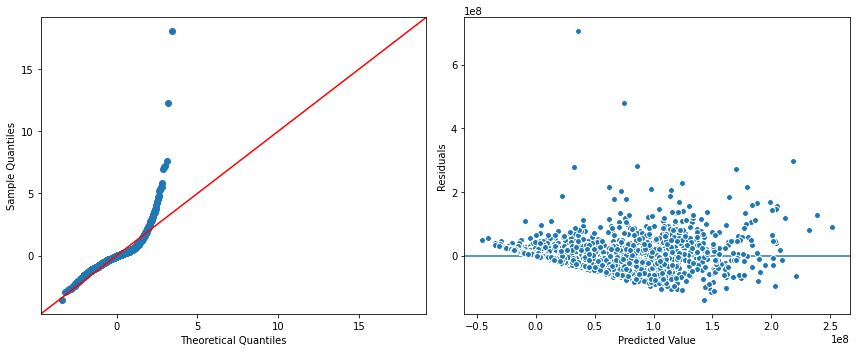

In [101]:
## MAKE NEW MODEL WITH IQR OUTLIERS REMOVED
## instantiate an OLS model WITH the training data.
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df_clean_iqr)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

> How are we doing??

In [104]:
## get pvalues from model result
pvals = result.pvalues
pvals

certification_G           8.798868e-04
certification_MISSING    1.241921e-109
certification_NC-17       3.597207e-05
certification_NR          3.599849e-03
certification_PG          2.716598e-01
certification_PG-13      8.674177e-119
certification_R           6.280202e-04
adult                     5.914702e-01
budget                    3.364553e-01
popularity                1.778701e-04
runtime                   7.635240e-04
vote_average              5.827899e-03
vote_count                1.290814e-03
year                      3.013502e-04
month                     8.685596e-04
day                       2.583541e-03
belongs_to_collection     3.168930e-28
Genre_Family              4.196978e-01
Genre_Animation           1.124924e-02
Genre_Science Fiction     3.592001e-15
Genre_Thriller            1.011935e-01
Genre_Mystery             7.914131e-01
Genre_Drama               2.429280e-03
Genre_Romance             4.739676e-02
Genre_Comedy              1.750372e-03
Genre_War                

In [106]:
## Check for p-values that are >.05
pvals[pvals >  .05]

certification_PG     0.271660
adult                0.591470
budget               0.336455
Genre_Family         0.419698
Genre_Thriller       0.101194
Genre_Mystery        0.791413
Genre_War            0.680409
Genre_Crime          0.104002
Genre_Action         0.082477
Genre_Adventure      0.233268
Genre_Horror         0.229978
Genre_Fantasy        0.657308
Genre_History        0.859546
Genre_Music          0.225599
Genre_Documentary    0.603563
dtype: float64

## Removing features - based on p-values

In [109]:
## Get list of ALL genre columns to see how many are sig
(pvals.loc[genre_cols] >  .05).value_counts(normalize=True)

True     0.631579
False    0.368421
dtype: float64

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     214.4
Date:                Wed, 15 Jun 2022   Prob (F-statistic):               0.00
Time:                        20:46:58   Log-Likelihood:                -57360.
No. Observations:                3015   AIC:                         1.148e+05
Df Residuals:                    2999   BIC:                         1.148e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G                0          0        nan        nan           0           0
certification_MISSING     1.1369      0.049     23.020      0.000       1.040       1.234
certification_NC-17    5.129e+05   9.75e+04      5.262      0.000    3.22e+05    7.04e+05
certification_NR       8.212e+04    4.3e+04      1.909      0.056   -2245.542    1.66e+05
certification_PG       2.645e+06   1.16e+06      2.274      0.023    3.65e+05    4.93e+06
certification_PG-13    1.967e+04   1018.170     19.315      0.000    1.77e+04    2.17e+04
certification_R       -3.432e+05   1.53e+05     -2.249      0.025   -6.42e+05   -4.39e+04
adult                 -2.689e+05   2.35e+05     -1.146      0.252   -7.29e+05    1.91e+05
budget                 1584.1052   9.43e+04      0.017      0.987   -1.83e+05    1.86e+05
popularity             1.089e+08   3.85e+07      2.830      0.005    3.35e+07    1.84e+08
runtime                 8.42e+07   3.87e+07      2.175      0.030    8.31e+06     1.6e+08
vote_average            6.31e+07   3.99e+07      1.581      0.114   -1.51e+07    1.41e+08
vote_count             7.717e+07   3.87e+07      1.994      0.046    1.27e+06    1.53e+08
year                   9.149e+07   3.84e+07      2.382      0.017    1.62e+07    1.67e+08
month                  8.245e+07   3.83e+07      2.155      0.031    7.42e+06    1.57e+08
day                    6.808e+07   3.83e+07      1.778      0.076   -7.01e+06    1.43e+08
belongs_to_collection  2.521e+07   2.28e+06     11.058      0.000    2.07e+07    2.97e+07
const                  5.754e+08   2.68e+08      2.148      0.032    5.02e+07     1.1e+09
==============================================================================
Omnibus:                     3410.251   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           680932.735
Skew:                           5.470   Prob(JB):                         0.00
Kurtosis:                      75.806   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

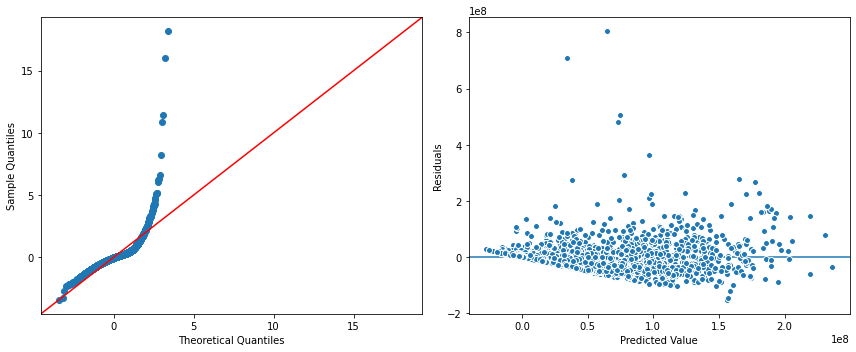

In [110]:
## Make x,y vars, but drop features with bad pvalues

df_model = df_clean_iqr.drop(columns=genre_cols)
X_train_df, X_test_df, y_train, y_test =get_train_test_split(df_model)
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result, X_train_df, y_train)

## MAKE AND EVALUATE OLS


# Addressing Multicollinearity

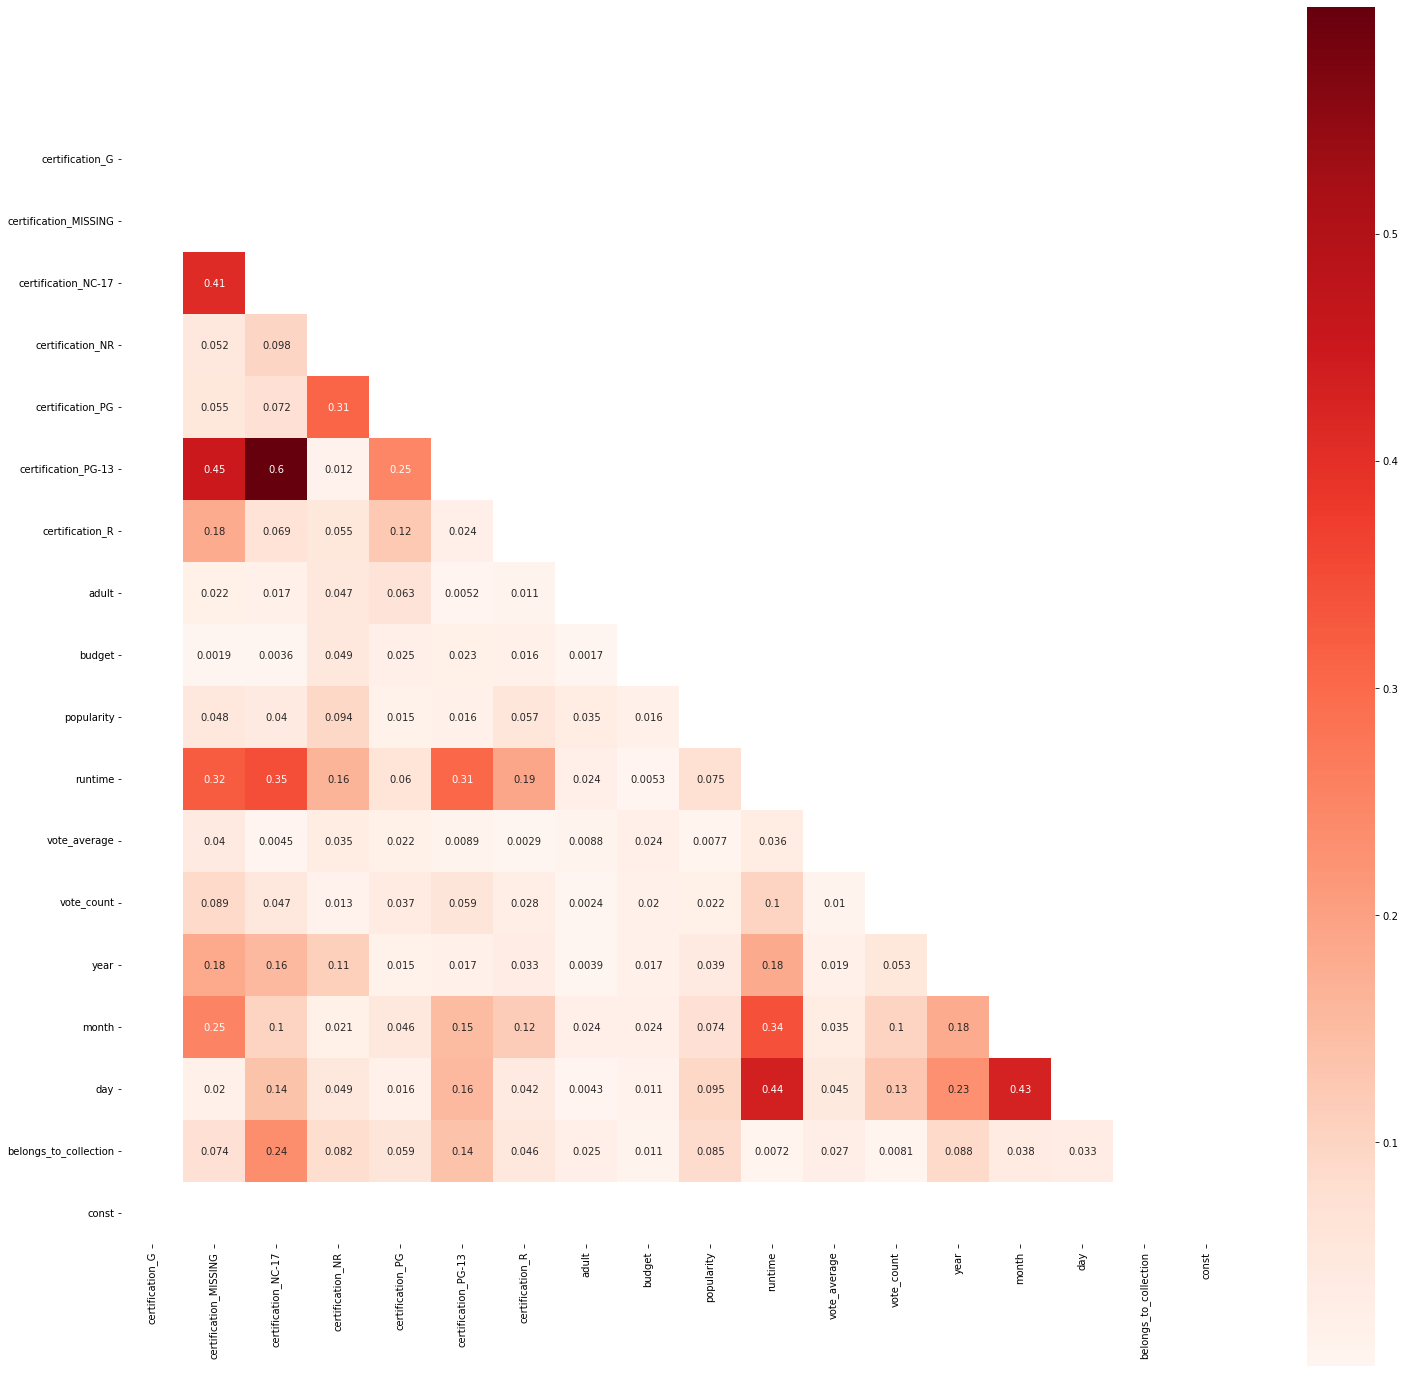

In [113]:
## Calculating the mask to hide the upper-right of the triangle
corr = X_train_df.corr().abs()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(25,25))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

### Variance Inflation Factor

In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# separate just x-data and subtract mean

features = X_train_df -  X_train_df.mean()

features

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,const
imdb_id,,,,,,,,,,,,,,,,,,
tt0790628,0.0,9.860334e+06,-2.068001,-8.337645,-0.702023,272.686235,2.909121,-3.767496,-1.240464,-0.01592,-0.256053,-0.003648,-0.028856,-0.087562,0.747927,-0.355887,-0.166501,0.0
tt7167630,0.0,-1.913967e+07,3.649999,-30.337645,0.397977,-385.313765,7.909121,-5.767496,-3.240464,-0.01592,-0.256053,-0.003648,-0.028856,-0.087562,-0.252073,0.644113,-0.166501,0.0
tt0283900,0.0,-1.483967e+07,-4.202001,13.662355,0.797977,-40.313765,-8.090879,-0.767496,3.759536,-0.01592,0.743947,-0.003648,-0.028856,-0.087562,-0.252073,-0.355887,0.833499,0.0
tt1524137,0.0,4.860334e+06,36.368999,0.662355,-0.002023,801.686235,1.909121,-5.767496,-3.240464,-0.01592,-0.256053,-0.003648,-0.028856,-0.087562,-0.252073,0.644113,-0.166501,0.0
tt2511670,0.0,-1.613967e+07,-11.785001,-31.337645,-0.102023,-883.313765,2.909121,5.232504,-11.240464,-0.01592,0.743947,-0.003648,-0.028856,-0.087562,-0.252073,-0.355887,-0.166501,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0412922,0.0,-1.975429e+07,10.546999,-24.337645,0.797977,-352.313765,-5.090879,2.232504,10.759536,-0.01592,-0.256053,-0.003648,-0.028856,0.912438,-0.252073,-0.355887,-0.166501,0.0
tt0340012,0.0,-2.139666e+06,-5.509001,-4.337645,0.297977,-863.313765,-6.090879,2.232504,-12.240464,-0.01592,-0.256053,-0.003648,-0.028856,-0.087562,-0.252073,0.644113,-0.166501,0.0
tt1646980,0.0,-3.139666e+06,14.144999,-10.337645,-0.502023,-411.313765,0.909121,3.232504,11.759536,-0.01592,-0.256053,-0.003648,-0.028856,-0.087562,0.747927,-0.355887,-0.166501,0.0


In [116]:
# create a list o# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]
vif_scores

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)
VIF


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


certification_G               NaN
certification_MISSING    1.602767
certification_NC-17      1.844011
certification_NR         1.204786
certification_PG         1.277641
certification_PG-13      1.962295
certification_R          1.123584
adult                    1.010257
budget                   1.006752
popularity                    inf
runtime                       inf
vote_average                  inf
vote_count                    inf
year                          inf
month                         inf
day                           inf
belongs_to_collection    1.103536
const                         NaN
dtype: float64

In [ ]:
## Sort VIF for inspect


In [ ]:
## Set float format to view vals not in scientfic notation


In [ ]:
## remove infinite values from VIF and sort


In [ ]:
## filter for VIF that are > 5


In [ ]:
## save name of features with high vif


### FInal Model

In [ ]:
## make new df_final copy of prev df

## FIT AND EVAL OLS



In [ ]:
## Visualize Coefficients


## Compare to Alternative Regressors

In [121]:
from sklearn.ensemble import RandomForestRegressor
X_train_df, X_test_df,y_train, y_test = get_train_test_split(df)

reg = RandomForestRegressor(verbose=1,random_state=42)
reg.fit(X_train_df, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


RandomForestRegressor(random_state=42, verbose=1)

In [122]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = reg.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = reg.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.971
Testing R^2: 0.795


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


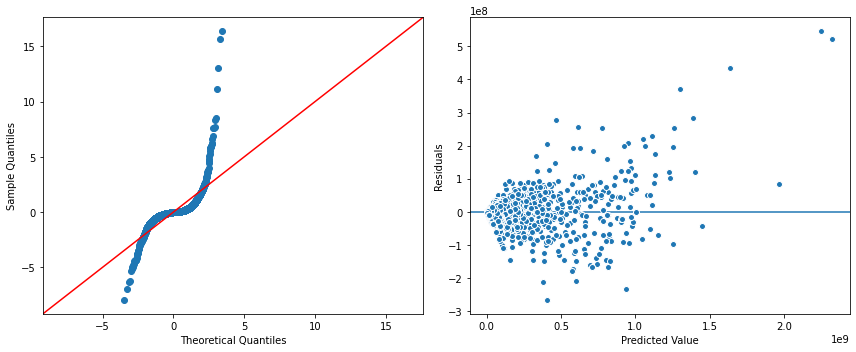

In [123]:
evaluate_ols(reg, X_train_df, y_train)

<AxesSubplot:>

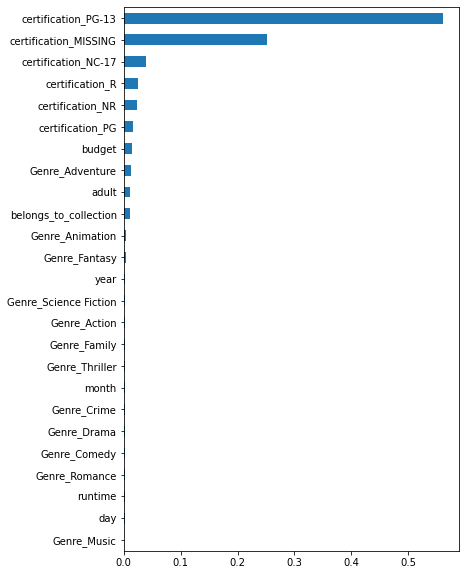

In [124]:
importances = pd.Series(reg.feature_importances_, index=X_train_df.columns)
importances.sort_values().tail(25).plot(kind='barh',figsize=(6,10))